In [ ]:
#| default_exp sgd

In [ ]:
#|export
import torch

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *

In [ ]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *

In [ ]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=160, sci_mode=False)

import logging
logging.disable(logging.WARNING)

set_seed(1103)
     

In [ ]:
fm_x, fm_y = "image", "label"
name = "fashion_mnist"
ds = load_dataset(name)

xmean = tensor(0.28)
xstd = tensor(0.35)

@inplace
def transformi(b):
    b["image"] = [(TF.to_tensor(i) - xmean) / xstd for i in b["image"]]
dst = ds.with_transform(transformi)

bs = 1024
dls = DataLoaders.from_dd(dst, bs)
xb, yb = next(iter(dls.train))

In [ ]:
stats = ActivationStats(lambda x: isinstance(x, GeneralReLU))
cbs = [DeviceCB(), stats, ProgressCB(plot=True), MetricsCB(accuracy=MulticlassAccuracy())]
leak = 0.1
act_init = partial(GeneralReLU, leak=leak, sub=0.5)
init_w = partial(init_weights, leak=leak)

# SGD

In [ ]:
class SGD:
    def __init__(self, params, lr=0.1, wd=0.0):
        self.params = list(params)
        self.lr = lr
        self.wd = wd

    def step(self):
        with torch.no_grad():
            for p in self.params:
                self.reg_step(p)
                self.opt_step(p)

    def opt_step(self, p):
        p -= p.grad * self.lr

    def reg_step(self, p):
        if self.wd > 0:
            p *= p * (1 - self.wd)

    def zero_grad(self):
        for p in self.params:
            p.grad.zero_()

accuracy,loss,epoch,train
0.759,0.684,0,train
0.808,0.534,0,valid
0.833,0.463,1,train
0.831,0.466,1,valid
0.851,0.413,2,train
0.846,0.428,2,valid


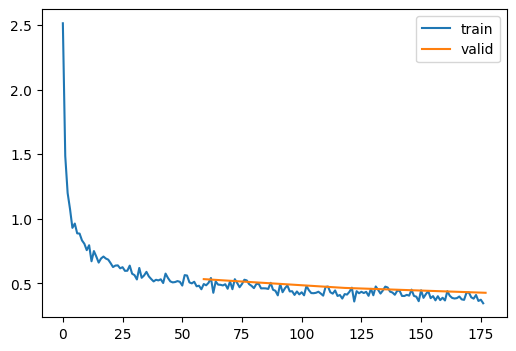

In [ ]:
set_seed(1103)
model = get_model(act=act_init, norm=nn.BatchNorm2d)
model = model.apply(init_w)
learn = TrainLearner(model, dls, F.cross_entropy, lr=0.15, cbs=cbs, opt_func=SGD)
learn.fit(3)

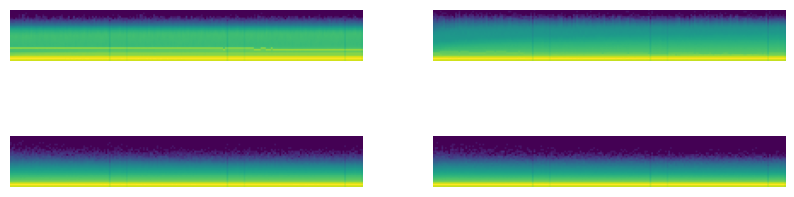

In [ ]:
stats.color_dim()

## Momentum

In [ ]:
class SGD:
    def __init__(self, params, lr=0.1, wd=0.0):
        self.params = list(params)
        self.lr = lr
        self.wd = wd

    def step(self):
        with torch.no_grad():
            for p in self.params:
                self.reg_step(p)
                self.opt_step(p)

    def opt_step(self, p):
        p -= p.grad * self.lr

    def reg_step(self, p):
        if self.wd > 0:
            p *= p * (1 - self.wd)

    def zero_grad(self):
        for p in self.params:
            p.grad.zero_()

In [ ]:
torch.lerp(tensor(1.), tensor(2.), 0.2)

tensor(1.20)

In [ ]:
class Momentum(SGD):
    def __init__(self, params, lr=0.1, wd=0.0, mom=0.8):
        super().__init__(params, lr, wd)
        self.mom = mom

    def opt_step(self, p):
        if not hasattr(p, "grad_avg"):
            p.grad_avg = torch.zeros_like(p.grad)

        p.grad_avg = torch.lerp(p.grad, p.grad_avg, self.mom)
        p -= p.grad_avg * self.lr

accuracy,loss,epoch,train
0.785,0.594,0,train
0.840,0.443,0,valid
0.860,0.384,1,train
0.854,0.398,1,valid
0.875,0.342,2,train
0.858,0.394,2,valid


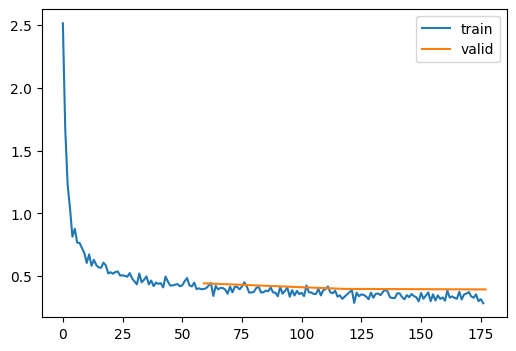

In [ ]:
set_seed(1103)
model = get_model(act=act_init, norm=nn.BatchNorm2d)
model = model.apply(init_w)
learn = TrainLearner(model, dls, F.cross_entropy, lr=0.5, cbs=cbs, opt_func=Momentum)
learn.fit(3)

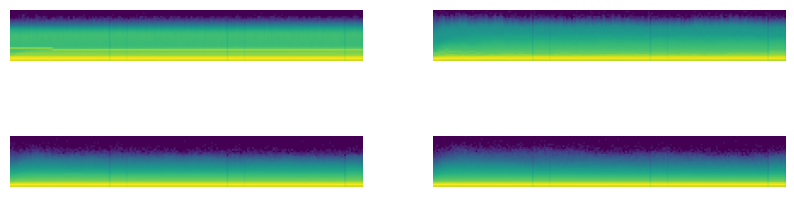

In [ ]:
stats.color_dim()

# RMSProp

In [ ]:
class RMSProp(SGD):
    def __init__(self, params, lr=0.1, wd=0.0, mom=0.8, eps=1e-4):
        super().__init__(params, lr, wd)
        self.mom = mom
        self.eps = eps

    def opt_step(self, p):
        if not hasattr(p, "grad_sq_avg"):
            # p.grad_sq_avg = torch.zeros_like(p.grad)
            p.grad_sq_avg = p.grad ** 2
        p.grad_sq_avg = torch.lerp(p.grad ** 2, p.grad_sq_avg, self.mom)
        p -= self.lr * p.grad / (p.grad_sq_avg.sqrt() + self.eps)

accuracy,loss,epoch,train
0.747,0.721,0,train
0.824,0.500,0,valid
0.848,0.406,1,train
0.848,0.419,1,valid
0.874,0.336,2,train
0.850,0.424,2,valid


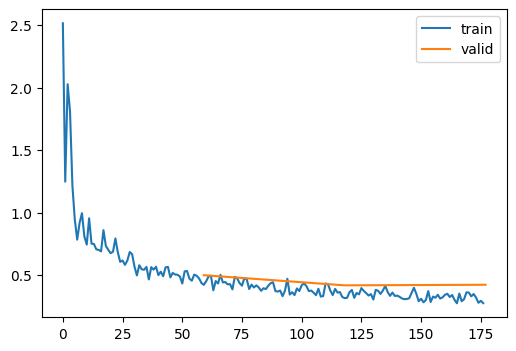

In [ ]:
set_seed(1103)
model = get_model(act=act_init, norm=nn.BatchNorm2d)
model = model.apply(init_w)
learn = TrainLearner(model, dls, F.cross_entropy, lr=0.01, cbs=cbs, opt_func=RMSProp)
learn.fit(3)

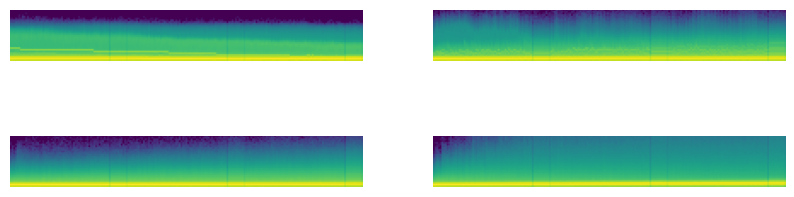

In [ ]:
stats.color_dim()

# Adam

In [ ]:
class RMSProp(SGD):
    def __init__(self, params, lr=0.1, wd=0.0, mom=0.8, eps=1e-4):
        super().__init__(params, lr, wd)
        self.mom = mom
        self.eps = eps

    def opt_step(self, p):
        if not hasattr(p, "grad_sq_avg"):
            # p.grad_sq_avg = torch.zeros_like(p.grad)
            p.grad_sq_avg = p.grad ** 2
        p.grad_sq_avg = torch.lerp(p.grad ** 2, p.grad_sq_avg, self.mom)
        p -= self.lr * p.grad / (p.grad_sq_avg.sqrt() + self.eps)

In [ ]:
class Adam(SGD):
    def __init__(self, params, lr=0.1, wd=0.0, beta1=0.9, beta2=0.999, eps=1e-4):
        super().__init__(params, lr, wd)
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.step_idx = 0

    def step(self):
        self.step_idx += 1
        super().step()

    def opt_step(self, p):
        if not hasattr(p, "grad_sq_avg"):
            p.grad_sq_avg = torch.zeros_like(p.grad)
            p.grad_avg = torch.zeros_like(p.grad)
        p.grad_avg = torch.lerp(p.grad, p.grad_avg, self.beta1)
        p.grad_sq_avg = torch.lerp(p.grad ** 2, p.grad_sq_avg, self.beta2)
        unbiased_avg = p.grad_avg / (1 - self.beta1 ** self.step_idx)
        unbiased_sq_avg = p.grad_sq_avg / (1 - self.beta2 ** self.step_idx)

        p -= self.lr * unbiased_avg / (unbiased_sq_avg.sqrt() + self.eps)

accuracy,loss,epoch,train
0.803,0.538,0,train
0.853,0.403,0,valid
0.874,0.344,1,train
0.869,0.367,1,valid
0.889,0.301,2,train
0.878,0.336,2,valid


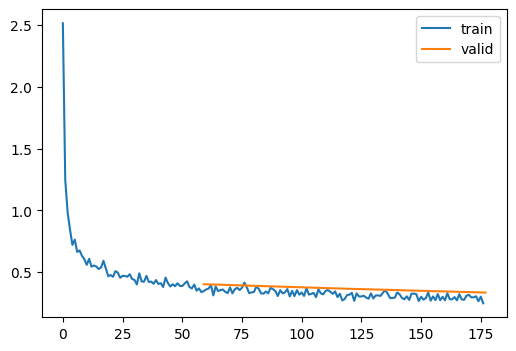

In [ ]:
set_seed(1103)
model = get_model(act=act_init, norm=nn.BatchNorm2d)
model = model.apply(init_w)
learn = TrainLearner(model, dls, F.cross_entropy, lr=0.01, cbs=cbs, opt_func=Adam)
learn.fit(3)

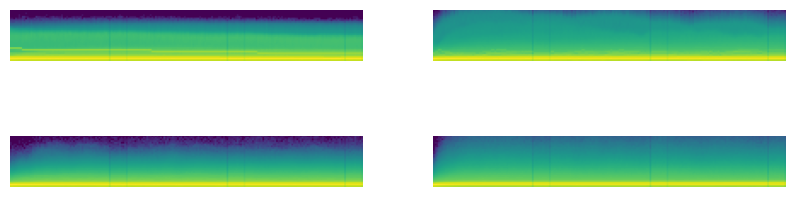

In [ ]:
stats.color_dim()

# Export

In [ ]:
import nbdev; nbdev.nbdev_export()